<a href="https://colab.research.google.com/github/KeshekaE/ColabUTD/blob/main/decisiontree_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
mush_train = pd.read_csv("mush_train.data", header=None)
mush_train.head(10)
mush_test = pd.read_csv("mush_test.data", header=None)
mush_test.head(10)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,f,y,f,f,f,c,b,p,...,k,n,b,p,w,o,l,h,y,g
1,p,x,f,g,f,f,f,c,b,g,...,k,p,n,p,w,o,l,h,v,p
2,p,x,f,y,f,f,f,c,b,g,...,k,n,b,p,w,o,l,h,y,p
3,e,f,y,n,t,n,f,c,b,n,...,s,g,p,p,w,o,p,k,y,d
4,p,f,f,g,f,f,f,c,b,p,...,k,p,p,p,w,o,l,h,y,g
5,p,x,s,e,f,f,f,c,n,b,...,k,w,p,p,w,o,e,w,v,d
6,p,x,f,g,f,f,f,c,b,h,...,k,n,p,p,w,o,l,h,v,p
7,e,x,y,g,t,n,f,c,b,u,...,s,g,p,p,w,o,p,n,v,d
8,p,k,y,e,f,y,f,c,n,b,...,s,p,p,p,w,o,e,w,v,d
9,e,f,s,w,f,n,f,w,b,p,...,f,w,w,p,w,o,e,n,a,g


In [3]:
train = mush_train.to_numpy()
test = mush_test.to_numpy()

x_train = train[:,1:]
y_train = train[:,0]

x_test = test[:,1:]
y_test = test[:,0]

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(4712, 22) (4712,)
(3412, 22) (3412,)


In [4]:
#constructing decision tree
class Node():
  def __init__(self, X, Y, parent, isInternal = True, branched_at=None):
    self.X = X
    self.Y = Y 
    self.parent = parent
    self.isInternal = isInternal
    self.child = []
    self.IG = 0 
    self.branched_at = branched_at

    if(len(set(Y)) == 1):
      self.leaf = True
      self.label = Y[0]
    else:
      self.leaf = False
      self.label = 'not a leaf'
    
      if((parent == None or isInternal) and (not self.leaf)):
        self.branch()

  def cond_entropy(self, xi):
    H_YXi = 0
    for cat in set(self.X[:,xi]): # pick the column rep the attribute 'xi'
      Y_cat = self.Y[np.where(self.X[:,xi]== cat)]
      e = len(np.where(Y_cat == 'e')[0])/ Y_cat.shape[0]
      p = len(np.where(Y_cat == 'p')[0])/Y_cat.shape[0]
      H_YXi -= (Y_cat.shape[0]/self.Y.shape[0]) * (np.log(e**e)+ np.log(p**p))

    return H_YXi

  def branch(self):
    e = len(np.where(self.Y=='e')[0])/self.Y.shape[0]
    p = len(np.where(self.Y=='p')[0])/self.Y.shape[0]
    H_Y = -(np.log(e**e)+np.log(p**p))

    if(self.branched_at == None):
      max_gain = 0

      for xi in range(self.X.shape[1]):
        H_Yxi = self.cond_entropy(xi)
        IG = H_Y - H_Yxi
        if(IG > max_gain) or (IG == max_gain and self.branched_at < xi):
          max_gain = IG
          self.branched_at = xi
      else:
        max_gain = H_Y = self.cond_entropy(self.branched_at)

      self.IG = max_gain
      self.label = 'IG=' + str(np.round(max_gain, 3)) + '\n at' + str(self.branched_at)

      for cat in set(self.X[:, self.branched_at]):
        X_c = self.X[np.where(self.X[:, self.branched_at] == cat)[0], :]
        Y_c = self.Y[np.where(self.X[:, self.branched_at] == cat)[0]]
        new_mode = Node(X_c, Y_c, self, self.isInternal)
        self.child.append(new_mode)


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

def plot_tree(main_node, index, dim):

  def dfs(mnode, pre_index):
    for node in mnode.child:
      index = node.label
      if(index in {'e', 'p'}):
        index = str(mnode.branched_at) + node.X[0, mnode.branched_at]+ '->' + index
      else:
        index = str(mnode.branched_at) + node.X[0, mnode.branched_at]+ '\n' + index

      Graph.add_node(index)
      Graph.add_edge(pre_index, index)
      dfs(node, index)


  Graph = nx.DiGraph()
  Graph.add_node(main_node.label)
  dfs(main_node, index)
  pos = graphviz_layout(Graph, prog='dot')
  plt.figure(figsize=dim)
  nx.draw(Graph, pos, with_labels=True, font_weight='bold', node_color='skyblue', alpha=1, node_size=1600)
  plt.show()

In [6]:
main_node = Node(x_train, y_train, None)

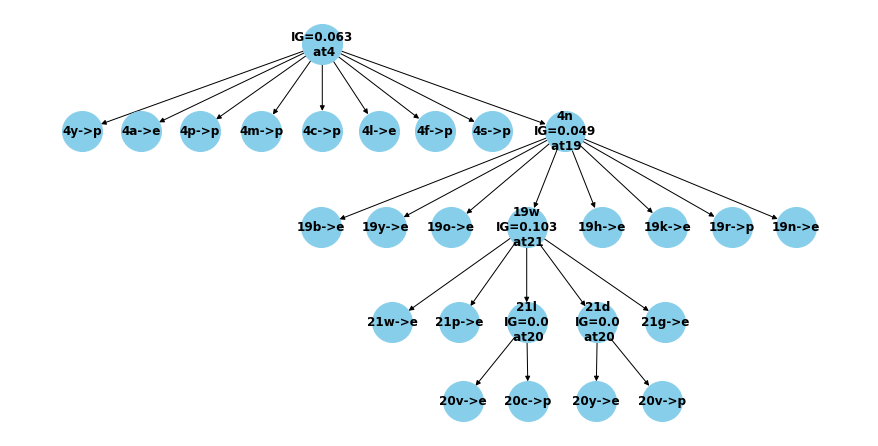

In [7]:
plot_tree(main_node, main_node.label, [12, 6])

In [8]:
def predict(X, main_node):
  Y_pred = []

  for i in range(X.shape[0]):
    cur_node = main_node

    while True:
      if(cur_node.label in set(y_train)):
        Y_pred.append(cur_node.label)
        break
      else:
        flag = 0
        for node in cur_node.child:
          check = list(set(node.X[:, cur_node.branched_at]))[0]
          if(X[i, cur_node.branched_at] == check):
            cur_node = node 
            flag = 1
            break
        if(flag == 0):
          Y_pred.append('Not found')
          break
  return Y_pred

In [9]:
print(predict(x_test[:10, :], main_node))

['p', 'p', 'p', 'e', 'p', 'p', 'p', 'e', 'p', 'e']
